<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Build-road-network-model" data-toc-modified-id="Build-road-network-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build road network model</a></span></li><li><span><a href="#Sample-origin-locations-based-on-population-density" data-toc-modified-id="Sample-origin-locations-based-on-population-density-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sample origin locations based on population density</a></span><ul class="toc-item"><li><span><a href="#Based-on-population-density" data-toc-modified-id="Based-on-population-density-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Based on population density</a></span></li></ul></li></ul></div>

# Libraries

In [13]:
import os
import sys
import networkx as nx
import osmnx as ox
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler

import warnings; warnings.simplefilter('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = 15

# Build road network model

In [3]:
# Specify file path of the Santiago convex hull
santiago_convexhull_path = '../../Air_pollution/02_data/santiago_pop_convex_hull.shp'

# Get graph (drive + service roads) from OSM
# define coordinate system as EPSG: 4326, WGS84 - World Geodetic System 1984, used in GPS
crs_lonlat = {'init': 'epsg:' + str(4326)}

# Read convex hull boundary file
bnd = gpd.read_file(santiago_convexhull_path).to_crs(crs_lonlat)

Simple plot of the boundary

<AxesSubplot:>

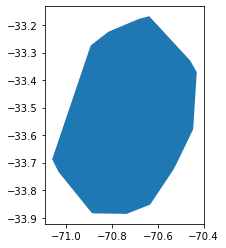

In [4]:
bnd.plot()

Extracting network from OSM database using OSMnx

In [5]:
# Create graph using OSMnx, extracting all available road networks
###
# method: osmnx.graph_from_polygon(.shp, network_type, etc.)
# ‘drive’         – get drivable public streets (but not service roads)
# ‘drive_service’ – get drivable public streets, including service roads
# ‘walk’          – get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
# ‘bike’         – get all streets and paths that cyclists can use
# ‘all’          – download all (non-private) OSM streets and paths
# ‘all_private’  – download all OSM streets and paths, including private-access ones
###
G = ox.graph_from_polygon(bnd.geometry[0], network_type='all_private')

In [6]:
# Save graph file as .pk
with open('../../Air_pollution/02_data/santiago_osmnx_all_private_graph.pk', 'wb') as handle:
    pickle.dump(G, handle, protocol=2)

In [8]:
# Save as shapefile
G_shp_out_dir = '../../Air_pollution/02_data/'
ox.io.save_graph_shapefile(G, filepath=G_shp_out_dir)

# Sample origin locations based on population density

In [14]:
# Directory where the raw exported attribute table is stored
santiago_pop_block_centroid_dir = "../../Air_pollution/02_data/santiago_block_centroids_raw.txt"
# Read table
santiago_pop_block_centroid_raw = pd.read_csv(santiago_pop_block_centroid_dir)
# Select useful columns: FID, TOTAL_PERS (population), centroid_x, centroid_y
santiago_pop_block_centroid_df = santiago_pop_block_centroid_raw[["FID", "TOTAL_PERS", "centroid_x", "centroid_y"]]

# Apply minmax scaler to the population column to create a sampling probability field
scaler = MinMaxScaler()
santiago_pop_block_centroid_df[["sample_prob_pop"]] = scaler.fit_transform(santiago_pop_block_centroid_df[["TOTAL_PERS"]])
santiago_pop_block_centroid_df.head()

,FID,TOTAL_PERS,centroid_x,centroid_y,sample_prob_pop
0,0,189.0,-7864610.0,-3958370.0,0.020550
1,1,80.0,-7874070.0,-3961680.0,0.008698
2,2,29.0,-7872570.0,-3961700.0,0.003153
3,3,146.0,-7864690.0,-3958370.0,0.015875
4,4,74.0,-7872050.0,-3961740.0,0.008046
